In [ ]:
import sys, os, re
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml, json
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import palettes
pio.renderers.default = "browser"

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)

from neural_analysis_helpers import get_psth, plot_avg_psth, split_psth, get_tuned_neurons, plot_avg_goal_psth, \
    get_landmark_psth, plot_avg_landmark_psth, plot_landmark_psth_map, plot_condition_psth_map, get_map_correlation, \
    get_tuned_neurons_shohei, get_rewards, get_rewarded_landmarks, get_landmark_category_entries, get_landmark_category_rew_idx, \
    get_landmark_categories, load_vr_behaviour_data, load_nidaq_behaviour_data, get_lm_entry_exit, load_vr_session_info, get_position_info

import parse_session_functions
importlib.reload(parse_session_functions)

# Athina's version - some function are slightly modified and some are new functions
from parse_session_functions import load_session, load_config, create_session_struct, get_lap_idx, get_lm_idx, calc_laps_needed, get_active_goal, get_rewarded_lms, get_lms_visited

tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)
hfs_palette = np.array(palettes.met_brew('Austria',n=8, brew_type="continuous"))

In [2]:

basepath = '/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2'
animal = 'TAA0000066'
# session = 'ses-010_date-20250314_protocol-t4'
# session = 'ses-011_date-20250315_protocol-t5'
# session = 'ses-012_date-20250318_protocol-t6'
session  = 'ses-018_date-20250403_protocol-t12'
sess_data_path = basepath + '/' + animal + '/' + session
func_img_path = 'funcimg/Session'
save_path = sess_data_path + '/analysis'
if not os.path.exists(save_path):
    os.makedirs(save_path)

protocol_num = int(re.search(r'protocol-t(\d+)', session).group(1))

if animal == 'TAA0000066' or animal == 'TAA0000059':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AB_shuffled'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'ABAB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
elif animal == 'TAA0000061' or animal == 'TAA0000064':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AABB'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'ABAB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
elif animal == 'TAA0000062' or animal == 'TAA0000065':
    if protocol_num == 3 or protocol_num == 4:
        sequence = 'AB_shuffled'
    elif protocol_num == 5 or protocol_num == 6:
        sequence = 'AABB'
    else:
        print('This code does not work before T3 or beyond T6 yet.')
else:
    raise ValueError("Oops I don't know what to do about this mouse")

# Recording params
nidaq_sampling_rate = 9000
vdaq_sampling_rate = 5000
funcimg_frame_rate = 45  # frames/s
if protocol_num <= 5:
    funcimg_recording_duration = 30 # min 
elif protocol_num >= 6:
    funcimg_recording_duration = 45 # min 
else:
    print('Please specify the funcimg recording duration!')
    
save_npz = True
save_csv = True

This code does not work before T3 or beyond T6 yet.


In [3]:
# Load data 

# Load nidaq data 
data = load_nidaq_behaviour_data(sess_data_path)
# print(data.files)

# Load behaviour relevant frames 
valid_frames = np.load(os.path.join(sess_data_path, 'valid_frames.npz'))['valid_frames']

# Load VR data 
position_data, options = load_vr_behaviour_data(sess_data_path)
session = create_session_struct(position_data, options)
session = get_lap_idx(session)
session = get_lm_idx(session)
session = get_rewarded_lms(session)
session = get_active_goal(session)
session = calc_laps_needed(session)
session = get_lms_visited(options, session)

print('Number of laps = ', session['num_laps'])
num_lms = len(session['all_landmarks'])
print('Number of landmarks visited = ', num_lms)

rulename = options['sequence_task']['rulename']
if rulename == 'run-auto' or rulename == 'run-lick':  # stages 1-2
    start_odour = False  # VR started with reward delivery
elif rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
    start_odour = True  # first VR event was the odour delivery prep

    if rulename == 'olfactory_test':
        num_landmarks = 10
    else:
        num_landmarks = 2
        # print('Please specify the number of landmarks in the corridor!')  # TODO: read this from config file

# Load suite2p outputs
ops = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/iscell.npy'))[:,0]

neurons = np.where(iscell == 1)[0]  # select ROIs that are classified as neurons
num_neurons = len(neurons)


Speed threshold: 10
Number of laps =  109
Number of landmarks visited =  1090


In [10]:
# Get landmark information 

# 1. Find data idx closest to landmark entry and exit
# TODO: depends on how the corridor is configured - write function for this 
lm_entry_idx, lm_exit_idx = get_lm_entry_exit(session, positions=data['position'])

# 3. Find licks
lick_idx = np.where(data['licks'] == 1)[0]

# 4. Find landmarks that were rewarded
rewarded_landmarks = get_rewarded_landmarks(position_data, data, session)
# print(session['rewarded_landmarks)

reward_idx = get_rewards(position_data, data)

In [11]:
# Load F and Fneu
calculate_DF_F = False

DF_F_file = os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/DF_F0.npy')

if os.path.exists(DF_F_file) and calculate_DF_F is False:
    print('DF_F0 file found. Loading...')
    
    DF_F_all = np.load(DF_F_file)
    DF_F = DF_F_all[:, valid_frames]
    print(DF_F.shape)
    
else:
    calculate_DF_F = True
    F = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/F.npy'))
    Fneu = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/Fneu.npy'))

(539, 121277)


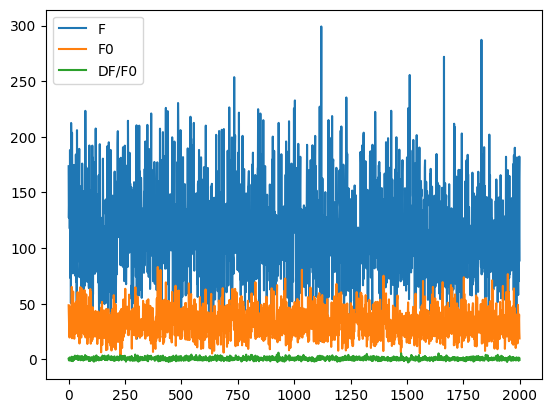

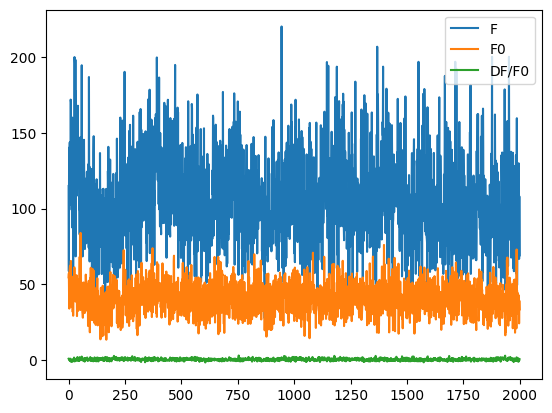

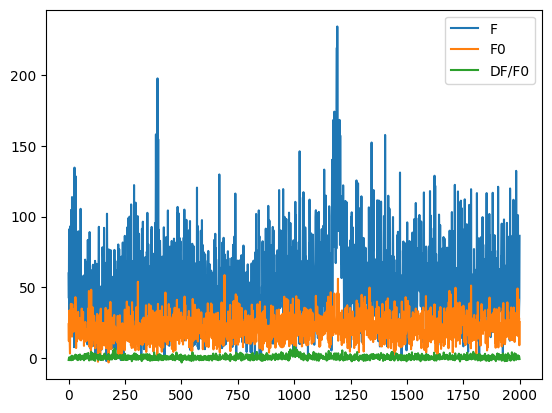

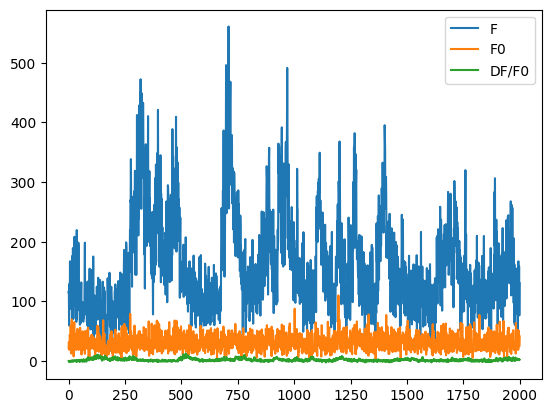

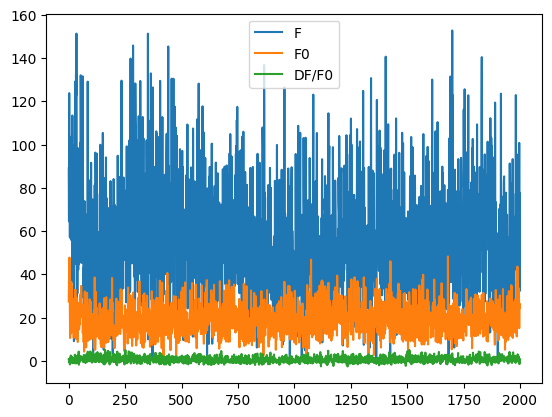

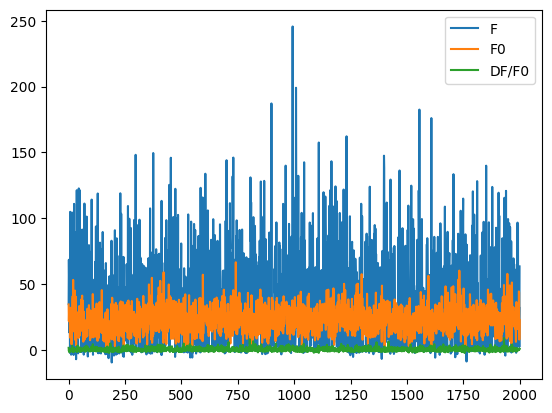

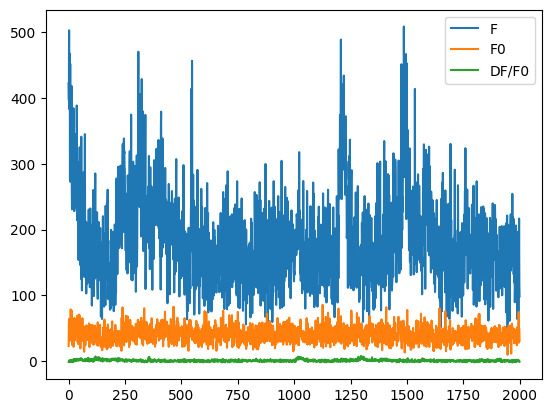

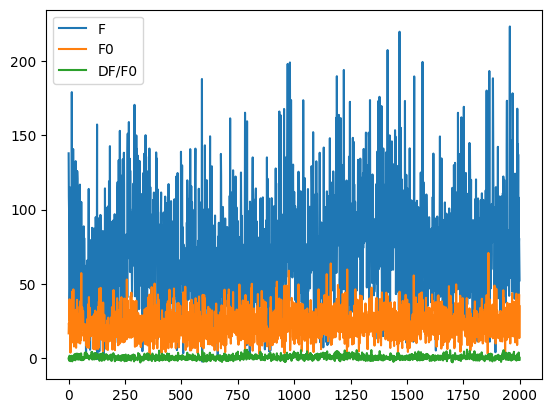

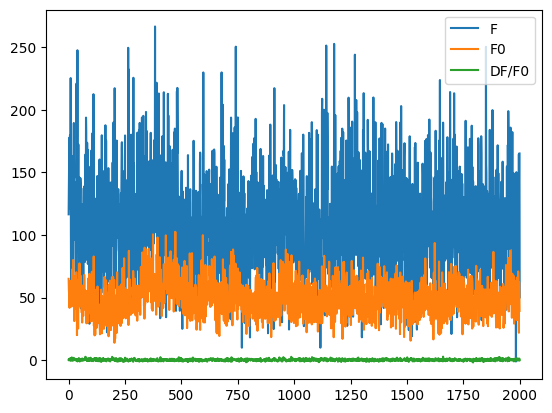

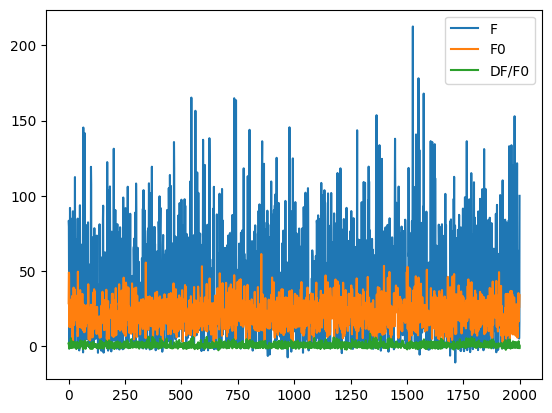

In [12]:
# Option 2 - suite2p: and dividing by mean F0 (https://github.com/MouseLand/suite2p/issues/598)
# For computing and subtracting baseline:
# baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
# sig_baseline: in bins, standard deviation of gaussian with which to smooth
# win_baseline: in seconds, window in which to compute max/min filters
if calculate_DF_F:
    prctile_baseline = 25

    F0 = 0.7 * Fneu
    mean_F0 = np.mean(F0, axis=1)

    DF = F.copy() - F0
    DF = dcnv.preprocess(DF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], prctile_baseline)

    DF_F_all = DF / mean_F0.reshape(-1, 1)  # normalize by mean F0  (https://suite2p.readthedocs.io/en/latest/FAQ.html)

    # Select the correct frames that fall within VR behaviour 
    DF_F = DF_F_all[:, valid_frames]
    print(DF_F.shape)

    for n in neurons[0:10]:
        plt.figure()
        plt.plot(F[n,0:2000], label='F')
        plt.plot(F0[n,0:2000], label='F0')
        plt.plot(DF_F[n,0:2000], label='DF/F0')
        plt.legend()

    # Save data 
    np.save(DF_F_file, DF_F_all)

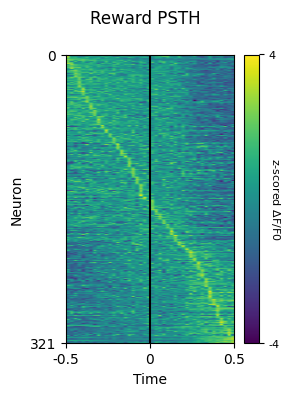

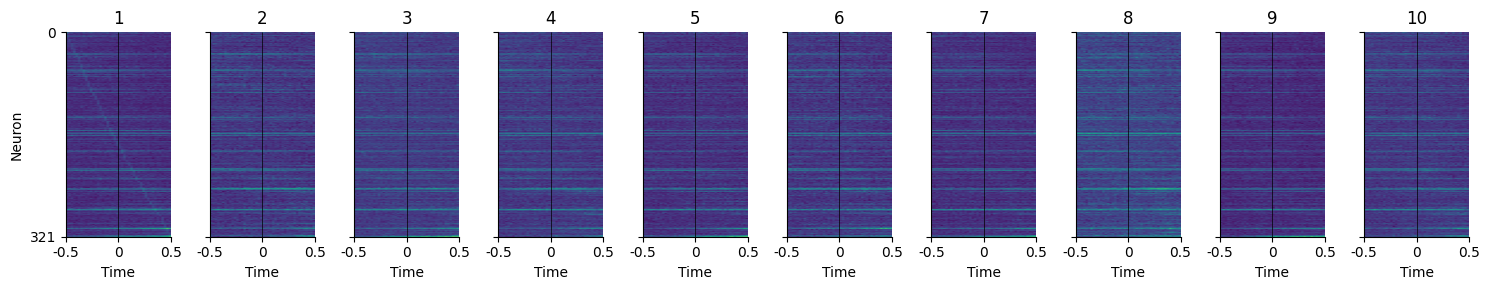

In [ ]:
# Get reward PSTH
# Initialize saving variables
time_around = 0.5
save_filename = os.path.join(save_path, f'T{protocol_num}_rewards_analysis_{time_around}s.npz')
reload_results = False


reward_psth, average_reward_psth = get_psth(data=DF_F, neurons=neurons, event_idx=reward_idx, \
                                                        time_around=time_around)
plot_avg_psth(average_reward_psth, event='Reward', zscoring=True, time_around=time_around)

